In [1]:
import pandas as pd
import warnings
import os
from pmdarima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

COMMON_PATH = os.path.dirname(os.getcwd())
PATH =  os.path.join(COMMON_PATH, r'data\train_datasets')
#SAVE_PATH = os.path.join(os.getcwd(), r'ML_models')

In [2]:
fintech = pd.read_csv('fintech.csv')
industrial_goods = pd.read_csv('industrial_goods.csv')
renewable_energy = pd.read_csv('renewable_energy.csv')
healthcare_services = pd.read_csv('healthcare_services.csv')

In [3]:
fintech.shape, industrial_goods.shape, renewable_energy.shape, healthcare_services.shape

((1976, 293), (1976, 309), (1976, 131), (1976, 259))

In [4]:
fintech.sample(3)

,volume_NTRS_USA,close_NTRS_USA,date,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,...,open_IMOEX,high_IMOEX,low_IMOEX,close_IMOEX,volume_IMOEX,Interbank credit market rates,gold_rates,silver_rates,platinum_rates,palladium_rates
1247,1038661.0,91.34,2019-05-24,945642.0,45.72,NaN,NaN,360700.0,20.29,NaN,...,2621.94,2642.40,2616.56,2619.24,4.971144e+10,7.3171,2645.61,30.02,1658.75,2718.28
643,1007066.0,120.86,2021-10-15,706549.0,82.80,9517534.0,280.61,1016200.0,51.45,NaN,...,4278.51,4282.15,4247.79,4261.82,9.258811e+10,6.8032,4147.69,53.87,2384.09,5031.28
720,852846.0,114.60,2021-06-28,1432968.0,72.30,7449035.0,246.69,1097300.0,46.83,NaN,...,3833.72,3852.83,3822.81,3825.57,6.098304e+10,5.4573,NaN,NaN,NaN,NaN


## Description of the variables

* **`date`** - The date of corresponding indicator values (**format: %Y-%m-%d**)
* **`close/volume_..._X`** - Close price/Trading volume of the specified share of the American(X=USA, **units=usd**)/Russian(X=RU, **units=rub**) company
* **`open/close/high/low/volume_IMOEX`** - Open/Close/High/Low price/Volume of the Moscow Exchange Index (**units=rub**)
* **`open/close/high/low/volume_S&P500`** - Open/Close/High/Low price/Volume of the S&P500 Index (**units=usd**)

* **`usdrub`** - Ruble to US dollar exchange rate (**1 US dollar --> x RUS rubles**)
* **`effr`** - Effective Federal Funds Rate (**units=%**)
* **`gold/silver/platinum/polladium_rates`** - Rates of gold/silver/platinum/polladium (**units=rub**)
* **`Interbank credit market rates`** - Rates at which banks lend to one another on the interbank market (**units=%**)

* **`m0_ru`** - Monetary base in Russia, including currency in circulation and bank reserves (**units=rub**)
* **`m1_ru`** - Money supply in Russia, including M0 plus demand deposits (**units=rub**)
* **`m2_ru`** - Money supply in Russia, including M1 plus short-term time deposits (**units=rub**)
* **`Credits`** - Total amount of credit issued by financial institutions (**units=rub**) 
* **`Deposits`** - Total amount of deposits held in financial institutions (**units=rub**)
* **`daily_gdp`** - Daily estimated Gross Domestic Product (**units=rub**)
* **`daily_gdp_no_season`** - Daily estimated Gross Domestic Product without seasonal adjustments (**units=rub**)
* **`real_gdp_usa`** - Real Gross Domestic Product of the USA adjusted for inflation (**units=rub**)
* **`Debt securities`** - Value of debt securities issued (**units=rub**)
* **`broad_money_supply_ru`** - Broad money supply in Russia, including M2 plus other liquid assets (**units=rub**)
* **`Cash national currency`** - Total amount of cash in the national currency in circulation (**units=rub**)
* **`Foreign currency in cash`** - Total amount of foreign currency in cash in circulation (**units=rub**)
* **`Households and NPOs, total`** - Total financial assets and liabilities of households and non-profit organizations (**units=rub**)
* **`Cash on brokerage accounts`** - Total value of loans received from credit institutions (**units=usd**)
* **`Non-financial sector, total`** - Total financial assets and liabilities of the non-financial sector (**units=usd**)
* **`Loans from credit institutions`** - Total value of loans received from credit institutions (**units=usd**)
* **`External borrowings, households`** - Total external borrowings by households (**units=usd**)
* **`Internal borrowings, households`** - Total internal borrowings by households (**units=usd**)
* **`External borrowings, non-financial sector`** - Total external borrowings by the non-financial sector (**units=usd**)
* **`Internal borrowings, non-financial sector`** - Total internal borrowings by the non-financial sector (**units=usd**)
* **`Debt securities in the residents portfolio`** - Value of debt securities held in the portfolios of residents (**units=usd**)
* **`Loans and borrowings received from non-residents`** - Total loans and borrowings received from non-residents (**units=usd**)
* **`Debt of the non-financial sector and households, total`** - Total debt of the non-financial sector and households (**units=usd**)
* **`Quoted shares and units and shares of investment funds`** - Value of quoted shares and units and shares of investment funds (**units=usd**)
* **`Debt securities in the portfolio of non-residents, including promissory notes`** - Value of debt securities, including promissory notes, held in the portfolios of non-residents (**units=usd**)

## Processing of Nans/passes

**Notebook content:**
* Firstly, we **[print total number of NaNs](#step1)**.
* Secondly, using the example of **[fintech](#fintech_example)** sector, we **[process features](#the_beginning)** with all needed justifications.
* Then we **[create a function](#step3)**, based on code in (2), for the remaining 3 sectors (without detailed comments).
* One by one, we manually **[examine the possible reasons for NaNs of all shares](#step4)**, one after another.
* In [this step](#step5) we **fill all remaining NaNs via ARIMA model**.


<a id='step1'></a>
# Step №1.

In [5]:
print(f'Initial (total) amount of NaNs')
print()
print(f'In fintech data: {fintech.isna().sum().sum()}')
print(f'In industrial goods data: {industrial_goods.isna().sum().sum()}')
print(f'In renewable energy data: {renewable_energy.isna().sum().sum()}')
print(f'In healthcare services data: {healthcare_services.isna().sum().sum()}')

Initial (total) amount of NaNs

In fintech data: 208642
In industrial goods data: 209596
In renewable energy data: 94342
In healthcare services data: 178072


# Step №2.

The FMP website allows parsing quotes of American stocks for the past 5 years only. Consequently, auxiliary variables have been created.

In [6]:
the_day_of_parsing = pd.to_datetime('2024-05-08', format='%Y-%m-%d')
threshold = the_day_of_parsing - pd.DateOffset(years=5)

<a id='fintech_example'></a>
## Fintech

In [7]:
fintech['date'] = pd.to_datetime(fintech['date'], format='%Y-%m-%d')
print(f'Lets see initial fintech dataset shape: {fintech.shape}')

Lets see initial fintech dataset shape: (1976, 293)


In [8]:
fintech.isna().sum().sort_values(ascending=False)

close_MBNK_RU      1968
volume_MBNK_RU     1968
close_CARM_RU      1758
volume_CARM_RU     1758
volume_CRBG_USA    1562
                   ... 
m0_ru                29
m1_ru                29
m2_ru                29
effr                 29
date                  0
Length: 293, dtype: int64

**The first step of processing:** to facilitate the identification of the reasons for missing data, we will create an indicator column named `is_workday`, which takes two values: `True` for weekdays and `False` for weekends/holidays. For this, we will refer to the calendar data we parsed earlier.

In [9]:
calendar = pd.read_csv('data/trading_calendat_NYSE.csv')
calendar.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
calendar['Date'] = pd.to_datetime(calendar['Date'], format='%Y-%m-%d')
calendar['Date'].dtype

dtype('<M8[ns]')

**The first step of the investigation:** upon reviewing the table, we realized that we need to trim the data to only include the last 5 years from the parsing date, as FMP provides stock quotes only for the past 5 years.

In [11]:
work_calendar = calendar[calendar['Date'] > threshold]
fintech['is_workday'] = [i in work_calendar['Date'].dt.date for i in fintech['date'].dt.date]
fintech = fintech[fintech['date'] > threshold]

In [12]:
work_calendar['Date']

1346   2019-05-09
1347   2019-05-10
1348   2019-05-13
1349   2019-05-14
1350   2019-05-15
          ...    
2598   2024-04-30
2599   2024-05-01
2600   2024-05-02
2601   2024-05-03
2602   2024-05-06
Name: Date, Length: 1257, dtype: datetime64[ns]

For research convenience, we will create a new column indicating **the day of the week**.

In [13]:
fintech['day_of_week'] = fintech['date'].dt.day_name()

In [14]:
fintech.set_index(['date'], inplace=True)
fintech.sort_index(inplace=True)

**Observation:** after parsing the `S&P500` and `IMOEX` data, each index provided 5 indicators (`high`, `low`, `open`, `close`, `volume`). We determined that the gaps between `high-low` and `close-open` might be particularly useful, so we can reduce the 5 indicators for each index to 4: `volume`, `gap_hl` = `high-low`, `gap_co` = `close-open`, and `close`.

In [15]:
fintech['gap_hl_S&P500'] = fintech['high_S&P500'] - fintech['low_S&P500']
fintech['gap_co_S&P500'] = fintech['close_S&P500'] - fintech['open_S&P500']
fintech['gap_hl_IMOEX'] = fintech['high_IMOEX'] - fintech['low_IMOEX']
fintech['gap_co_IMOEX'] = fintech['close_IMOEX'] - fintech['open_IMOEX']

In [16]:
fintech.drop(['high_IMOEX', 'low_IMOEX', 'open_IMOEX', 'high_S&P500', 'low_S&P500', 'open_S&P500'], axis=1, inplace=True)

In [17]:
fintech[fintech['volume_IMOEX'].isnull()].sample(5)

,volume_NTRS_USA,close_NTRS_USA,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,close_CARM_RU,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,Sunday,NaN,NaN,NaN,NaN
2020-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4842.82,63.78,2236.54,6044.10,False,Sunday,NaN,NaN,NaN,NaN
2021-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4221.29,61.94,2589.34,6577.49,False,Sunday,NaN,NaN,NaN,NaN
2022-02-23,812089.0,113.64,1332550.0,87.04,3892472.0,172.74,4233900.0,44.5,NaN,NaN,...,4899.60,61.37,2800.14,6151.00,False,Wednesday,11.91,-10.71,NaN,NaN
2023-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5754.79,71.34,2747.46,3654.45,False,Sunday,NaN,NaN,NaN,NaN


**Observation:** Most of the data was not parsed over the weekend. This can be explained by the fact that (almost) everyone rests on weekends. For holidays, we will refrain from making immediate conclusions since it depends on the organization.

**Solution:** We will discard these data, as they are not useful.

In [18]:
fintech = fintech[(fintech['day_of_week'] != 'Sunday') & (fintech['day_of_week'] != 'Saturday')]

In [19]:
print(f'Lets see current amount of NaNs: {fintech.isna().sum().sum()}')

Lets see current amount of NaNs: 39657


It is also important to remember that if the parsing of American stock data **did not occur today**, we need to trim the data according to the value of the variable `the_day_of_parsing`.

In [20]:
fintech = fintech[fintech.index <= the_day_of_parsing]

In [21]:
print(f'Lets see current amount of NaNs: {fintech.isna().sum().sum()} and fintech dataset shape: {fintech.shape}')

Lets see current amount of NaNs: 35105 and fintech dataset shape: (1305, 292)


In [22]:
fintech.isna().sum().sort_values(ascending=False)

volume_MBNK_RU     1298
close_MBNK_RU      1298
volume_CARM_RU     1088
close_CARM_RU      1088
volume_CRBG_USA     891
                   ... 
m1_ru                 6
m2_ru                 6
effr                  6
is_workday            0
day_of_week           0
Length: 292, dtype: int64

In [23]:
list_of_features = fintech.isna().sum().sort_values(ascending=False).index
filtered_columns = [col for col in list_of_features if not (col.startswith('volume_') or col.startswith('close_') or (fintech[col].isna().sum() == 0))]
filtered_columns

['palladium_rates',
 'platinum_rates',
 'silver_rates',
 'gold_rates',
 'usdrub',
 'Interbank credit market rates',
 'daily_gdp',
 'daily_gdp_no_season',
 'gap_co_IMOEX',
 'gap_hl_IMOEX',
 'gap_co_S&P500',
 'gap_hl_S&P500',
 'Foreign currency in cash',
 'Loans from credit institutions',
 'Quoted shares and units and shares of investment funds',
 'Debt securities',
 'Cash on brokerage accounts',
 'Deposits',
 'Cash national currency',
 'Debt securities in the portfolio of non-residents, including promissory notes',
 'Debt of the non-financial sector and households, total',
 'Non-financial sector, total',
 'Internal borrowings, non-financial sector',
 'Credits',
 'Debt securities in the residents portfolio',
 'External borrowings, non-financial sector',
 'Loans and borrowings received from non-residents',
 'Households and NPOs, total',
 'Internal borrowings, households',
 'External borrowings, households',
 'real_gdp_usa',
 'broad_money_supply_ru',
 'm0_ru',
 'm1_ru',
 'm2_ru',
 'effr']

**Overall**, we will use two methods for filling in missing data: naive prediction via `.ffill()` for features that investors potentially consider when making decisions. We do this because investors indeed rely on previous (most recent available) values. Additionally, we will use `ARIMA` for predicting and filling gaps in macroeconomic indicators and the previously highlighted `PRMB`.

We will use `.ffill()` to process the following features: `usdrub`, `palladium_rates`, `platinum_rates`, `silver_rates`, `gold_rates`, `IMOEX_close`, `IMOEX_volume`, `IMOEX_gap_hl`, `IMOEX_gap_co`, `S&P500_close`, `S&P500_gap_co`, `S&P500_gap_hl`, `S&P500_volume`, `effr`.

<a id='the_beginning'></a>
## Research of currency rates and precious metals

**Note:** Investigating the possible causes of missing data in `usdrub`, `gold_rates`, `silver_rates`, `platinum_rates`, and `palladium_rates`, it is noteworthy that in 205 out of 311 Mondays, these rates were not available. It seems that the Central Bank might be using [Friday's rates on Mondays](http://www.cs.ucl.ac.uk/fileadmin/UCL-CS/images/Research_Student_Information/RN_11_01.pdf). However, there is a clear bias for this day of the week, providing further justification for using `fill forward`.

In [24]:
fintech[~(fintech['usdrub'].isnull()) & (fintech['day_of_week'] == 'Monday')].shape

(56, 292)

In [25]:
fintech[(fintech['usdrub'].isnull()) & (fintech['day_of_week'] == 'Monday')].shape

(205, 292)

In [26]:
fintech['usdrub'] = fintech['usdrub'].ffill()
fintech['gold_rates'] = fintech['gold_rates'].ffill()
fintech['silver_rates'] = fintech['silver_rates'].ffill()
fintech['platinum_rates'] = fintech['platinum_rates'].ffill()
fintech['palladium_rates'] = fintech['palladium_rates'].ffill()

In [27]:
fintech['gold_rates'].isna().sum()

0

## Research of IMOEX and S&P500

In [28]:
fintech[fintech['volume_IMOEX'].isnull()]

,volume_NTRS_USA,close_NTRS_USA,volume_EWBC_USA,close_EWBC_USA,volume_COIN_USA,close_COIN_USA,volume_CG_USA,close_CG_USA,volume_CARM_RU,close_CARM_RU,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,804008.0,96.97,748222.0,50.17,NaN,NaN,593700.0,20.76,NaN,NaN,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.0300,1.43,NaN,NaN
2019-06-12,2207877.0,88.01,1765096.0,43.50,NaN,NaN,281900.0,21.57,NaN,NaN,...,3025.36,35.14,1823.92,3816.07,False,Wednesday,1.4400,-0.25,NaN,NaN
2019-11-04,691773.0,103.87,1119061.0,45.43,NaN,NaN,976300.0,27.98,NaN,NaN,...,2715.75,31.73,1854.48,2884.75,False,Monday,1.0400,-0.48,NaN,NaN
2019-12-31,741362.0,106.24,1167529.0,48.70,NaN,NaN,1362600.0,32.08,NaN,NaN,...,3008.36,35.48,1896.77,3795.53,False,Tuesday,1.9800,1.33,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3031.25,35.48,1932.59,3821.40,False,Wednesday,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,1098178.0,81.48,667150.0,72.36,7191183.0,165.9800,1864387.0,44.64,NaN,NaN,...,6043.85,68.81,2689.80,2901.53,False,Friday,3.0300,-1.42,NaN,NaN
2024-03-08,1225456.0,81.81,1038029.0,76.82,21883952.0,256.6200,2165911.0,47.35,NaN,NaN,...,6814.03,78.37,2805.70,2787.94,False,Friday,7.0901,-3.74,NaN,NaN
2024-05-01,1062849.0,83.05,758016.0,75.56,10191466.0,210.0900,6031390.0,40.97,NaN,NaN,...,6872.79,80.33,2680.69,2994.67,False,Wednesday,8.3250,-1.03,NaN,NaN


In the data for `S&P500` we did not reveal any patterns or reasons for the missing data. Therefore, we will simply fill in the gaps using `.ffill()`. For `IMOEX`, there is a specific time period, March 2022, when the data were not updated by the Moscow Exchange. Since the reason for the data gap is unclear, we decided to process `IMOEX` using `ARIMA`.

In [29]:
fintech['close_S&P500'] = fintech['close_S&P500'].ffill()
fintech['volume_S&P500'] = fintech['volume_S&P500'].ffill()
fintech['gap_hl_S&P500'] = fintech['gap_hl_S&P500'].ffill()
fintech['gap_co_S&P500'] = fintech['gap_co_S&P500'].ffill()

## Research of EFFR

In [30]:
print(f'Lets see current amount of NaNs in effr data: {fintech.isna().sum().sum()}')

Lets see current amount of NaNs in effr data: 33054


Upon examining where the gaps are for this feature, we observe that there are 6 missing values for the most recent dates, which is quite natural. Overall, we can either disregard these dates or fill them using `.ffill()`.

In [31]:
#fintech = fintech[fintech.index < '2024-05-01']

In [32]:
fintech['effr'] = fintech['effr'].ffill()

In [33]:
print(f'Lets see current amount of NaNs: {fintech.isna().sum().sum()}')

Lets see current amount of NaNs: 33048


<a id='step3'></a>
# Step №3. Common function for partial processing

In [34]:
def initial_processing(dataset):
    calendar = pd.read_csv('data/trading_calendat_NYSE.csv')
    calendar.drop(['Unnamed: 0'], axis=1, inplace=True)
    calendar['Date'] = pd.to_datetime(calendar['Date'], format='%Y-%m-%d')
    
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    
    # We create an auxiliary feature is_workday for clarity, filter out dates with missing data, 
    # and create a column day_of_week.
    work_calendar = calendar[calendar['Date'] > threshold]
    dataset['is_workday'] = [i in work_calendar['Date'].dt.date for i in dataset['date'].dt.date]
    dataset = dataset[dataset['date'] > threshold]
    dataset['day_of_week'] = dataset['date'].dt.day_name()
    dataset.set_index(['date'], inplace=True)
    dataset.sort_index(inplace=True)
    
    # We create new features for the IMOEX and S&P500 indices.
    dataset['gap_hl_S&P500'] = dataset['high_S&P500'] - dataset['low_S&P500']
    dataset['gap_co_S&P500'] = dataset['close_S&P500'] - dataset['open_S&P500']
    dataset['gap_hl_IMOEX'] = dataset['high_IMOEX'] - dataset['low_IMOEX']
    dataset['gap_co_IMOEX'] = dataset['close_IMOEX'] - dataset['open_IMOEX']
    dataset.drop(['high_IMOEX', 'low_IMOEX', 'open_IMOEX', 'high_S&P500', 'low_S&P500', 'open_S&P500'], axis=1, inplace=True)
    
    # We remove weekends and select the necessary time period.
    dataset = dataset[(dataset['day_of_week'] != 'Sunday') & (dataset['day_of_week'] != 'Saturday')]
    dataset = dataset[dataset.index <= the_day_of_parsing]
    
    # Processing of precious metals and currency exchange rates.
    dataset['usdrub'] = dataset['usdrub'].ffill()
    dataset['gold_rates'] = dataset['gold_rates'].ffill()
    dataset['silver_rates'] = dataset['silver_rates'].ffill()
    dataset['platinum_rates'] = dataset['platinum_rates'].ffill()
    dataset['palladium_rates'] = dataset['palladium_rates'].ffill()

    # Processing of IMOEX and S&P500.
    dataset['close_S&P500'] = dataset['close_S&P500'].ffill()
    dataset['volume_S&P500'] = dataset['volume_S&P500'].ffill()
    dataset['gap_hl_S&P500'] = dataset['gap_hl_S&P500'].ffill()
    dataset['gap_co_S&P500'] = dataset['gap_co_S&P500'].ffill()
    
    # Processing of EFFR.
    dataset['effr'] = dataset['effr'].ffill()
    return dataset

### We apply the function to the remaining 3 sectors:

In [35]:
industrial_goods = initial_processing(industrial_goods)
renewable_energy = initial_processing(renewable_energy)
healthcare_services = initial_processing(healthcare_services)

<a id='step4'></a>
# Step №4. Research of Stock Price Data

**Note:** It should be noted that **for some companies, there is virtually no data available**. This could be because the specific websites from which we extracted the quotes did not store them for these companies. This could be because the companies are too unpopular or their stocks starting to trade much later than 2019, etc.

**For many** such companies' stocks, we will exclude them from our study. For convenience, we will divide the data into those with more than 500 missing values and those with 150 to 500 missing values (this range requires closer inspection as they have a higher chance of remaining with manual imputation).

## Fintech
P.S. Overall, the conclusions drawn here **are universal for the following sectors** (excluding specific details down to the stock name).

In [36]:
ft_exceptions = list(fintech.isna().sum()[fintech.isna().sum() < 500].index)
fintech_1 = fintech.loc[:, ~fintech.columns.isin(ft_exceptions)]
fintech_1.isna().sum().sort_values(ascending=False)

volume_MBNK_RU     1298
close_MBNK_RU      1298
volume_CARM_RU     1088
close_CARM_RU      1088
close_CRBG_USA      891
volume_CRBG_USA     891
close_TPG_USA       723
volume_TPG_USA      723
close_POSI_RU       722
volume_POSI_RU      702
close_SPBE_RU       702
volume_NU_USA       699
close_NU_USA        699
volume_SPBE_RU      682
close_RENI_RU       682
volume_RENI_RU      661
volume_HOOD_USA     606
close_HOOD_USA      606
close_RYAN_USA      601
volume_RYAN_USA     601
close_COIN_USA      532
volume_COIN_USA     532
dtype: int64

In [37]:
ft_many_nans_1 = list(fintech_1.isna().sum().sort_values(ascending=False).index)

Examine certain stocks individually: why do they have so many NaNs?

**Process Description:** Several potential reasons for the large number of missing values were considered: either the company entered the financial market very recently (relative to the 2019-2024 period), or, in the case of Russian companies, their stocks were traded in different modes (not only TQBR) - a hypothesis at the level of speculation, or the specific website from which we obtained the quotes did not provide data for a certain period.

As it turns out, **the main reason for most of the missing data** is that the company listed its shares on the financial market recently. **The reason for the imbalances (in volume/close)** is that zeros were parsed instead of missing values in some cases.

In [38]:
fintech.isna().sum()[(fintech.isna().sum() > 500) | (fintech.isna().sum() < 150)].index

Index(['volume_NTRS_USA', 'close_NTRS_USA', 'volume_EWBC_USA',
       'close_EWBC_USA', 'volume_COIN_USA', 'close_COIN_USA', 'volume_CG_USA',
       'close_CG_USA', 'volume_CARM_RU', 'close_CARM_RU',
       ...
       'gold_rates', 'silver_rates', 'platinum_rates', 'palladium_rates',
       'is_workday', 'day_of_week', 'gap_hl_S&P500', 'gap_co_S&P500',
       'gap_hl_IMOEX', 'gap_co_IMOEX'],
      dtype='object', length=275)

In [39]:
ft_exceptions_1 = list(fintech.isna().sum()[(fintech.isna().sum() > 500) | (fintech.isna().sum() < 150)].index)
fintech_2 = fintech.loc[:, ~fintech.columns.isin(ft_exceptions_1)]
fintech_2.isna().sum().sort_values(ascending=False)

volume_OWL_USA                   450
close_OWL_USA                    450
close_SMLT_RU                    434
volume_SMLT_RU                   414
close_RKT_USA                    360
volume_RKT_USA                   360
close_INGR_RU                    286
volume_UWMC_USA                  282
close_UWMC_USA                   282
volume_INGR_RU                   266
close_PRMB_RU                    226
Interbank credit market rates    224
close_RDRB_RU                    219
close_TCSG_RU                    203
volume_XP_USA                    196
close_XP_USA                     196
volume_TCSG_RU                   163
dtype: int64

In [40]:
#fintech_2.isna().sum().sort_values(ascending=False).drop(['usdrub', 'palladium_rates', 'platinum_rates', 'silver_rates', 'gold_rates', 'Interbank credit market rates'])

**Intermediate Conclusion:** After investigating all stocks with more than 10% missing values, it can be said that almost all share a common reason: **a recent listing on the stock market**. The exceptions are `INGR` and `PRMB`: for `INGR`, there is suspicion that the data was incorrectly parsed, or the Moscow Exchange did not publish it for an extended period; for `PRMB`, the missing values are not consecutive but sporadic, making it possible **to fill them after predicting the values**.

In [41]:
ft_many_nans_2 = list(fintech_2.isna().sum().sort_values(ascending=False).index)
#drop(['usdrub', 'palladium_rates', 'platinum_rates', 'silver_rates', 'gold_rates', 'Interbank credit market rates', 'close_PRMB_RU']).index)

In [42]:
ft_many_nans_2

['volume_OWL_USA',
 'close_OWL_USA',
 'close_SMLT_RU',
 'volume_SMLT_RU',
 'close_RKT_USA',
 'volume_RKT_USA',
 'close_INGR_RU',
 'volume_UWMC_USA',
 'close_UWMC_USA',
 'volume_INGR_RU',
 'close_PRMB_RU',
 'Interbank credit market rates',
 'close_RDRB_RU',
 'close_TCSG_RU',
 'volume_XP_USA',
 'close_XP_USA',
 'volume_TCSG_RU']

We decided to discard the stock quotes for `INGR` because the parsing was correctly implemented, and this case represents an odd exception that is difficult to handle.

**Conclusion:** we eliminate data on 19 stocks (`MBNK`, `CARM`, `CRBG`, `TPG`, `POSI`, `SPBE`, `NU`, `RENI`, `HOOD`, `RYAN`, `COIN`, `OWL`, `SMLT`, `RKT`, `INGR`, `UWMC`, `RDRB`, `TCSG`, `XP`)

In [43]:
all_columns_to_drop_in_ft = ft_many_nans_1 + ft_many_nans_2
fintech.drop(all_columns_to_drop_in_ft, axis=1, inplace=True)

## Industrial goods

In [44]:
industrial_goods.head()

,volume_CLH_USA,close_CLH_USA,volume_BLDR_USA,close_BLDR_USA,volume_GGG_USA,close_GGG_USA,volume_RTX_USA,close_RTX_USA,volume_GWW_USA,close_GWW_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,502075.0,69.78,931345.0,16.70,476482.0,50.87,4066569.0,86.13,490500.0,273.44,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,548266.0,69.92,1670463.0,16.48,570537.0,51.41,4214823.0,86.32,456600.0,267.69,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,244584.0,68.00,1018554.0,15.81,542908.0,49.86,6545091.0,83.05,687600.0,259.99,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,450234.0,68.17,818879.0,16.08,1187857.0,48.76,4305078.0,84.32,354600.0,262.06,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,189946.0,68.05,875703.0,16.15,719101.0,48.90,3861588.0,84.32,363400.0,261.79,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [45]:
ig_exceptions = list(industrial_goods.isna().sum()[industrial_goods.isna().sum() < 500].index)
industrial_goods_1 = industrial_goods.loc[:, ~industrial_goods.columns.isin(ig_exceptions)]
industrial_goods_1.isna().sum().sort_values(ascending=False)

volume_UGLD_RU     1190
close_UGLD_RU      1190
volume_VLTO_USA    1150
close_VLTO_USA     1150
volume_PRFN_RU      993
close_PRFN_RU       993
close_UWGN_RU       651
volume_UWGN_RU      649
volume_CNM_USA      601
close_CNM_USA       601
close_SGZH_RU       557
volume_SGZH_RU      537
volume_SYM_USA      507
close_SYM_USA       507
dtype: int64

In [46]:
ig_many_nans_1 = list(industrial_goods_1.isna().sum().sort_values(ascending=False).index)

In [47]:
ig_exceptions_1 = list(industrial_goods.isna().sum()[(industrial_goods.isna().sum() > 500) | (industrial_goods.isna().sum() < 150)].index)
industrial_goods_2 = industrial_goods.loc[:, ~industrial_goods.columns.isin(ig_exceptions_1)]
industrial_goods_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_CARR_USA    263
close_CARR_USA     263
volume_OTIS_USA    263
close_OTIS_USA     263
volume_GFL_USA     251
close_GFL_USA      251
dtype: int64

In [48]:
ig_many_nans_2 = list(industrial_goods_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Intermediate Conclusion:** Did we decide to retain any stocks?

For two stocks (`PRFN_RU` and `UWGN_RU`), the reason for the missing data differs from the others: they began trading around 2019 or much earlier, but the data was parsed for a shorter time period. Since our parsers are correctly implemented and there are already many stocks to research, we decided to disregard this case, assuming the reason is the late appearance of data on `moex/fmp`.

**Conclusion:** we eliminate data on 10 stocks (`UGLD`, `VLTO`, `PRFN`, `UWGN`, `CNM`, `SGZH`, `SYM`, `CARR`, `OTIS`, `GFL`).

In [49]:
all_columns_to_drop_in_ig = ig_many_nans_1 + ig_many_nans_2
industrial_goods.drop(all_columns_to_drop_in_ig, axis=1, inplace=True)

## Renewable energy

In [50]:
renewable_energy.head()

,volume_UPRO_RU,close_UPRO_RU,volume_AMTX_USA,close_AMTX_USA,volume_CEG_USA,close_CEG_USA,volume_TPIC_USA,close_TPIC_USA,volume_NXT_USA,close_NXT_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,NaN,NaN,182000.0,1.13,NaN,NaN,808169.0,24.52,NaN,NaN,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,10250000.0,2.631,142100.0,1.11,NaN,NaN,589916.0,24.37,NaN,NaN,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,17350000.0,2.641,121000.0,1.08,NaN,NaN,621285.0,23.11,NaN,NaN,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,25134000.0,2.640,121800.0,1.16,NaN,NaN,767031.0,22.01,NaN,NaN,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,35968000.0,2.580,124000.0,1.19,NaN,NaN,523199.0,22.54,NaN,NaN,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [51]:
re_exceptions = list(renewable_energy.isna().sum()[renewable_energy.isna().sum() < 500].index)
renewable_energy_1 = renewable_energy.loc[:, ~renewable_energy.columns.isin(re_exceptions)]
renewable_energy_1.isna().sum().sort_values(ascending=False)

volume_GEV_USA     1275
close_GEV_USA      1275
volume_SMXT_USA    1252
close_SMXT_USA     1252
close_VSTE_USA     1208
volume_VSTE_USA    1208
volume_NXT_USA     1024
close_NXT_USA      1024
close_ENLT_USA      998
volume_ENLT_USA     998
volume_CEG_USA      726
close_CEG_USA       726
volume_ZEO_USA      704
close_ZEO_USA       704
volume_IMPP_USA     696
close_IMPP_USA      696
close_FLNC_USA      670
volume_FLNC_USA     670
dtype: int64

In [52]:
re_many_nans_1 = list(renewable_energy_1.isna().sum().sort_values(ascending=False).index)

In [53]:
re_exceptions_1 = list(renewable_energy.isna().sum()[(renewable_energy.isna().sum() > 500) | (renewable_energy.isna().sum() < 150)].index)
renewable_energy_2 = renewable_energy.loc[:, ~renewable_energy.columns.isin(re_exceptions_1)]
renewable_energy_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_RNW_USA     482
close_RNW_USA      482
volume_SHLS_USA    479
close_SHLS_USA     479
volume_ARRY_USA    409
close_ARRY_USA     409
volume_MAXN_USA    374
close_MAXN_USA     374
close_ENPG_RU      259
volume_ENPG_RU     239
dtype: int64

In [54]:
re_many_nans_2 = list(renewable_energy_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Intermediate Conclusion:** Did we decide to retain any stocks?

For two stocks (`NXT_USA` and `MPP_USA`), the reason for the missing data, like that for `industrial goods`, differs from the others. Our decision remains unchanged.

**Conclusion:** we eliminate data on 14 stocks (`GEV`, `SMXT`, `VSTE`, `NXT`, `ENLT`, `CEG`, `ZEO`, `MPP`, `FLNC`, `RNW`, `SHLS`, `ARRY`, `MAXN`, `ENPG`).

In [55]:
all_columns_to_drop_in_re = re_many_nans_1 + re_many_nans_2
renewable_energy.drop(all_columns_to_drop_in_re, axis=1, inplace=True)

## Healthcare services

In [56]:
healthcare_services.head()

,volume_DHR_USA,close_DHR_USA,volume_CHE_USA,close_CHE_USA,volume_COR_USA,close_COR_USA,volume_AMGN_USA,close_AMGN_USA,volume_BIO_USA,close_BIO_USA,...,gold_rates,silver_rates,platinum_rates,palladium_rates,is_workday,day_of_week,gap_hl_S&P500,gap_co_S&P500,gap_hl_IMOEX,gap_co_IMOEX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-09,2464934.0,116.42,96300.0,332.55,1774000.0,79.18,2854400.0,172.87,411176.0,309.28,...,3290.00,41.27,2069.61,3303.26,False,Thursday,4.03,1.43,NaN,NaN
2019-05-10,1791091.0,116.72,127100.0,334.63,1336100.0,77.47,2942300.0,171.85,395472.0,311.10,...,3156.00,36.81,1848.23,3472.75,False,Friday,6.64,2.48,29.17,-23.29
2019-05-13,2621471.0,114.75,171000.0,331.89,1087000.0,75.68,3371800.0,167.60,281162.0,296.28,...,3156.00,36.81,1848.23,3472.75,False,Monday,3.56,-1.56,25.07,-3.36
2019-05-14,1984989.0,115.90,117700.0,329.33,1605100.0,76.69,2525300.0,167.81,274589.0,291.97,...,2700.50,30.86,1795.49,2807.96,False,Tuesday,3.25,1.41,57.99,53.40
2019-05-15,1860640.0,116.16,58300.0,332.69,1333300.0,77.86,2860200.0,169.87,182146.0,294.35,...,2724.24,30.98,1795.03,2792.26,False,Wednesday,4.41,3.47,27.39,-14.84


In [57]:
hs_exceptions = list(healthcare_services.isna().sum()[healthcare_services.isna().sum() < 500].index)
healthcare_services_1 = healthcare_services.loc[:, ~healthcare_services.columns.isin(hs_exceptions)]
healthcare_services_1.isna().sum().sort_values(ascending=False)

volume_ABIO_RU     1122
close_ABIO_RU      1122
close_GECO_RU      1043
volume_GECO_RU     1042
volume_GEHC_USA     955
close_GEHC_USA      955
close_GEMC_RU       640
volume_STVN_USA     597
close_STVN_USA      597
volume_GEMC_RU      592
dtype: int64

In [58]:
hs_many_nans_1 = list(healthcare_services_1.isna().sum().sort_values(ascending=False).index)

In [59]:
hs_exceptions_1 = list(healthcare_services.isna().sum()[(healthcare_services.isna().sum() > 500) | (healthcare_services.isna().sum() < 150)].index)
healthcare_services_2 = healthcare_services.loc[:, ~healthcare_services.columns.isin(hs_exceptions_1)]
healthcare_services_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates')

volume_ROIV_USA    446
close_ROIV_USA     446
close_MDMG_RU      442
volume_MDMG_RU     420
volume_CERE_USA    355
close_CERE_USA     355
volume_RPRX_USA    324
close_RPRX_USA     324
volume_PCVX_USA    322
close_PCVX_USA     322
dtype: int64

In [60]:
hs_many_nans_2 = list(healthcare_services_2.isna().sum().sort_values(ascending=False).drop('Interbank credit market rates').index)

**Intermediate Conclusion:** Did we decide to retain any stocks?

For one stock (`ABIO_RU`), the reason for the missing data, like that in previous sectors, differs from the others. Our decision remains unchanged.

**Conclusion:** we eliminate data on 10 stocks (`ABIO`, `GECO`, `GEHC`, `STVN`, `GEMC`, `ROIV`, `MDMG`, `CERE`, `RPRX`, `PCVX`).

In [61]:
all_columns_to_drop_in_hs = hs_many_nans_1 + hs_many_nans_2
healthcare_services.drop(all_columns_to_drop_in_hs, axis=1, inplace=True)

<a id='step5'></a>
# Step №5. ARIMA model

Interpolation with ARIMA consists of 4 steps:
1. For each column algorithm finds the first date that contains no missing values
2. Each column is filled with simple interpolation: `.ffill()` method
3. ARIMA is automatically fitted to each column
4. Missing values are filled with ARIME predictions

**NB!** Make sure indices of input DataFrame are dates sorted in ascending order.

In [62]:
def interpolate(series):
    '''
    series: pd.Series
    '''
    series_filled = series.fillna(method = 'ffill')
    series_filled = series_filled.fillna(method = 'bfill')
    model = auto_arima(series_filled, seasonal=True, 
                       stepwise=True, suppress_warnings=True, 
                       error_action="ignore", trace=False)
    model.fit(series_filled)
    forecast = model.predict_in_sample()
    interpolated_series = series.copy()
    interpolated_series[series.isna()] = forecast[series.isna()]

    return interpolated_series

def find_first_date(series):
    '''
    series: pd.Series with dates as indices in ascending order

    returns
    Datetime - first data with no nans
    '''
    return series.index.values[~series.isnull()][0]

def interpolate_df(df, column_list):
    '''
    Function finds the first date with no nans for all chosen columns
    and interpolate time series since this date
    
    df: pd.DataFrame with dates as indices in ascending order
    column_list: str[] - columns to interpolate

    returns
    pd.DataFrame
    '''
    first_date = max([find_first_date(df[col]) for col in column_list])
    df = df[df.index >= first_date]
    df.loc[:, column_list] = df[column_list].apply(lambda x: interpolate(x), axis=0)
    
    return df

def process_df(df, path):
    '''
    Function finds the first date with no nans for all chosen columns
    and interpolate time series since this date

    df: pd.DataFrame
    path: path to \data\{sector}

    returni
    pd.DataFrame
    '''
    ticker_names = os.listdir(path)
    columns_names = list(set([col for col in df.columns for ticker_name in ticker_names if ticker_name[:-4] in col]))
    columns_names += [col for col in df.columns if ('IMOEX' in col) or ('S&P500' in col)]
    columns_names += ['m0_ru', 'm1_ru', 'm2_ru', 'broad_money_supply_ru']
    columns_names += ['Cash national currency', 'Foreign currency in cash', 
                     'Deposits', 'Cash on brokerage accounts',
                     'Debt securities', 'Quoted shares and units and shares of investment funds',
                     'Loans from credit institutions']
    
    columns_names += [
    "Debt of the non-financial sector and households, total",
    "Non-financial sector, total",
    "Internal borrowings, non-financial sector",
    "Credits",
    "Debt securities in the residents portfolio",
    "External borrowings, non-financial sector",
    "Loans and borrowings received from non-residents",
    "Debt securities in the portfolio of non-residents, including promissory notes",
    "Households and NPOs, total",
    "Internal borrowings, households",
    "External borrowings, households"
]

    return interpolate_df(df, columns_names)
    

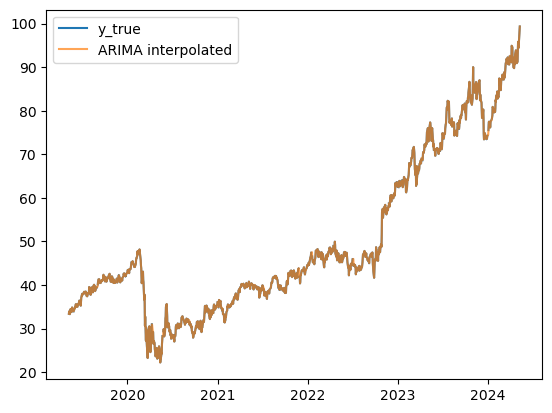

In [63]:
# That's why it's important to exclude first dates with missing values 
series = fintech['close_ACGL_USA']
interpolated = interpolate(series)

plt.plot(series, label = 'y_true')
plt.plot(interpolated, label = 'ARIMA interpolated', alpha = 0.7)
plt.legend();

In [64]:
fintech.isna().sum().sum()

11010

In [ ]:
df = process_df(fintech, os.path.join(PATH, 'fintech'))
df.to_csv('final_fintech.csv', encoding = 'utf-8')